# A simple apprach

In [37]:
import random
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

In [71]:
def get_vals(B):
    mu = 1
    sigma = 0.1
    vals = []
    for i in range(B):
        v = abs((random.gauss(mu, sigma)))
        vals.append(v)
    return vals


def get_weights(B):
    W_total = 0
    W_list = []
    weights = []
    for i in range(B):
        W = random.randint(1,B)
        W_total += W
        W_list.append(W)
    for i in range(B):
        w = W_list[i]/W_total
        weights.append(w)  
    return weights
        
def get_weights2(vals):
    weights2 = [v for v in vals]
    norm = sum(weights2)
    weights2 = [(w)/norm for w in weights2]
    return weights2



def roll(vals,weights,comms_to_fire_rate):
    #returns the outcome (value) of the roll and sets the selected index in vals to zero
    
    B = len(weights)
    if (sum(weights)==0):
        #if there are no weights left, return zero
        return 0
    else:
        #get the index
        lucky_index = np.random.choice(B, 1, p=weights)[0]
        #collect the value
        v = vals[lucky_index]
        # change the element to have zero value (changes propegate outside the scope of this function)
        vals[lucky_index]=0
    
    #if you have comms, sometimes take out the probability of returning to this box
    if (comms_to_fire_rate > 0):
        r = random.uniform(0, 1)
        if (float(comms_to_fire_rate>=r)):
            weights[lucky_index]=0
            norm = sum(weights)
            if (norm>0):
                weights[:] = [w/norm for w in weights] #need the [:] to change array within function

    return v


def rolls(vals,weights,R,comms_to_fire_rate):
    total_value = 0
    for i in range(R):
        v = roll(vals,weights,comms_to_fire_rate)
        total_value += v
    return total_value


def play_game(B,R,trials,comms_to_fire_rate):
    vals_original = get_vals(B)

    #get perfect outcome
    vals = vals_original[:]
    vals.sort(reverse=True)
    p = sum(vals[:R])
    perfect_outcomes = [p]*trials
    
    #get outcomes with flat weights
    outcomes = []
    weights_original = get_weights(B)
    for i in range(trials):
        #use the same, but fresh, set of vals and weights for each trial
        vals = vals_original[:]
        weights = weights_original[:]
        o = rolls(vals,weights,R,comms_to_fire_rate)
        outcomes.append(o)

    #get outcomes with value-mirrored weights
    outcomes2 = []
    weights2_original = get_weights2(vals_original)
    for i in range(trials):
        #use the same, but fresh, set of vals for each trial
        vals = vals_original[:]
        weights2 = weights2_original[:]
        o = rolls(vals,weights2,R,comms_to_fire_rate)
        outcomes2.append(o)
        
    return (vals_original,weights_original,perfect_outcomes,outcomes,outcomes2)


In [72]:
# def plot_one_game():
#     B = 1
#     R = 1
#     trials = 1
#     vals,weights,perfect_outcomes,outcomes,outcomes2 = play_game(B,R,trials)
#     normalized_outcomes = [o/float(R) for o in outcomes]
#     plt.hist(vals, density=True, alpha=0.5, label='target values')
#     plt.hist(normalized_outcomes, density=False, alpha=0.5, label='value per strike')
#     plt.legend(loc='upper right')
#     plt.ylabel('Probability')
#     plt.xlabel('Data')

In [73]:
def summarize_B_scan(B_list,R,trials,comms_to_fire_rate=0):
    #takes in a list of B values and returns a list of means and a list of stds (for fixed 'R' and 'trials' numbers)
    m00_list = []
    s00_list = []
    m0_list = []
    s0_list = []
    m1_list = []
    s1_list = []
    m2_list = []
    s2_list = []
    for B in B_list:
        #run a game
        vals,weights,perfect_outcomes,outcomes,outcomes2 = play_game(B,R,trials,comms_to_fire_rate)
        normalized_perfect_outcomes = [o/float(R) for o in perfect_outcomes]
        normalized_outcomes = [o/float(R) for o in outcomes]
        normalized_outcomes2 = [o/float(R) for o in outcomes2]
        #summarize
        m00 = np.mean(vals)
        s00 = np.std(vals) 
        m0 = np.mean(normalized_perfect_outcomes)
        s0 = np.std(normalized_perfect_outcomes)
        m1 = np.mean(normalized_outcomes)
        s1 = np.std(normalized_outcomes)
        m2 = np.mean(normalized_outcomes2)
        s2 = np.std(normalized_outcomes2)
        #store summary in lists
        m00_list.append(m00)
        s00_list.append(s00)
        m0_list.append(m0)
        s0_list.append(s0)
        m1_list.append(m1)
        s1_list.append(s1)
        m2_list.append(m2)
        s2_list.append(s2)
    return (m00_list,s00_list,m0_list,s0_list,m1_list,s1_list,m2_list,s2_list)

In [74]:
R = 40
trials = 50
B_low = 5
B_high=200
B_step = 5
B_high +=B_step
B_list = list(range(B_low,B_high,B_step)) 
ratio_list = [B/R for B in B_list]

m00_list,s00_list,m0_list,s0_list,m1_list,s1_list,m2_list,s2_list = summarize_B_scan(B_list,R,trials)
dummy,dummy,dummy,dummy,dummy,dummy,m2_comms_list,s2_comms_list = summarize_B_scan(B_list,R,trials,comms_to_fire_rate=0.5)

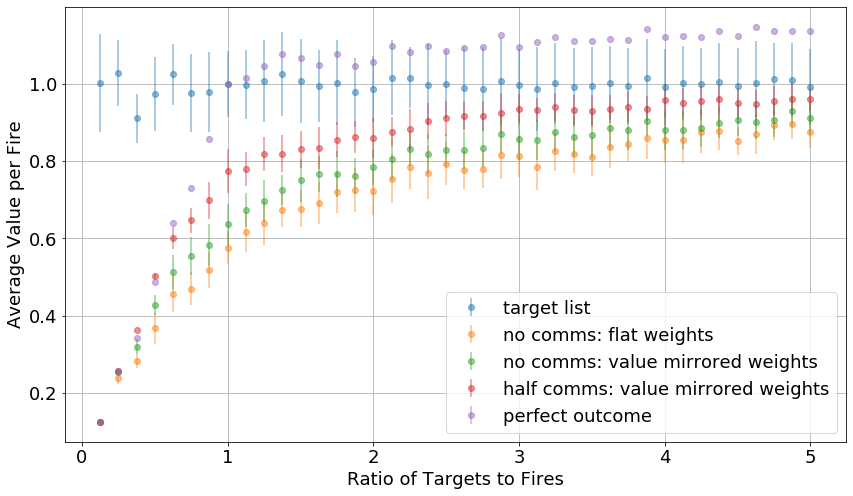

In [75]:
fig = plt.figure(figsize=(14, 8))
plt.errorbar(ratio_list, m00_list, yerr=s00_list, fmt='o',alpha=0.5,label="target list")
plt.errorbar(ratio_list, m1_list, yerr=s1_list, fmt='o',alpha=0.5,label="no comms: flat weights")
plt.errorbar(ratio_list, m2_list, yerr=s2_list, fmt='o',alpha=0.5, label="no comms: value mirrored weights")
plt.errorbar(ratio_list, m2_comms_list, yerr=s2_comms_list, fmt='o',alpha=0.5, label="half comms: value mirrored weights")
plt.errorbar(ratio_list, m0_list, yerr=s0_list, fmt='o',alpha=0.5,label="perfect outcome")

plt.legend(loc='lower right')
plt.ylabel('Average Value per Fire')
plt.xlabel('Ratio of Targets to Fires')
plt.grid()
plt.show()

In [76]:
def summarize_comms_scan(B,R,trials,comms_to_fire_rate_list):
    #takes in a list of B values and returns a list of means and a list of stds (for fixed 'R' and 'trials' numbers)
    m00_list = []
    s00_list = []
    m0_list = []
    s0_list = []
    m1_list = []
    s1_list = []
    m2_list = []
    s2_list = []
    for comms_to_fire_rate in comms_to_fire_rate_list:
        #run a game
        vals,weights,perfect_outcomes,outcomes,outcomes2 = play_game(B,R,trials,comms_to_fire_rate)
        normalized_perfect_outcomes = [o/float(R) for o in perfect_outcomes]
        normalized_outcomes = [o/float(R) for o in outcomes]
        normalized_outcomes2 = [o/float(R) for o in outcomes2]
        #summarize
        m00 = np.mean(vals)
        s00 = np.std(vals) 
        m0 = np.mean(normalized_perfect_outcomes)
        s0 = np.std(normalized_perfect_outcomes)
        m1 = np.mean(normalized_outcomes)
        s1 = np.std(normalized_outcomes)
        m2 = np.mean(normalized_outcomes2)
        s2 = np.std(normalized_outcomes2)
        #store summary in lists
        m00_list.append(m00)
        s00_list.append(s00)
        m0_list.append(m0)
        s0_list.append(s0)
        m1_list.append(m1)
        s1_list.append(s1)
        m2_list.append(m2)
        s2_list.append(s2)
    return (m00_list,s00_list,m0_list,s0_list,m1_list,s1_list,m2_list,s2_list)

In [77]:
R = 40
B = 40
trials = 100

comms_to_fire_rate_list = [(i)*0.1 for i in range(11)]
m00_list,s00_list,m0_list,s0_list,m1_list,s1_list,m2_list,s2_list = summarize_comms_scan(B,R,trials,comms_to_fire_rate_list)

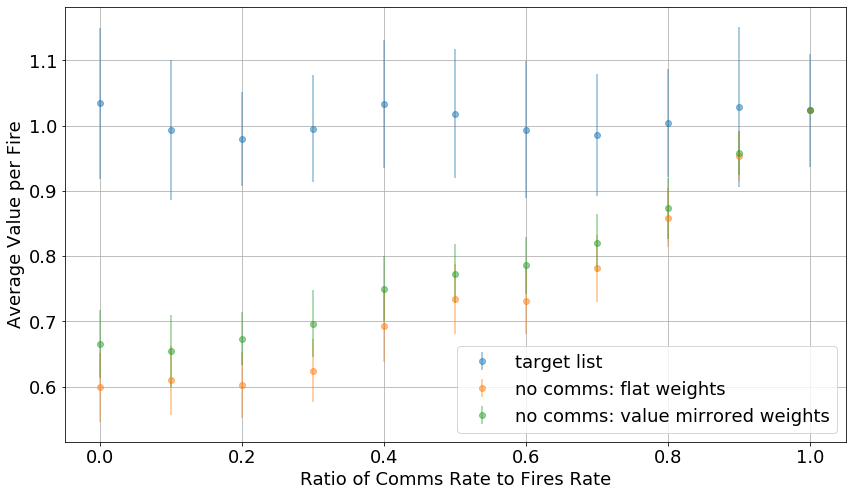

In [78]:

fig = plt.figure(figsize=(14, 8))
plt.errorbar(comms_to_fire_rate_list, m00_list, yerr=s00_list, fmt='o',alpha=0.5,label="target list")
plt.errorbar(comms_to_fire_rate_list, m1_list, yerr=s1_list, fmt='o',alpha=0.5,label="no comms: flat weights")
plt.errorbar(comms_to_fire_rate_list, m2_list, yerr=s2_list, fmt='o',alpha=0.5, label="no comms: value mirrored weights")

plt.legend(loc='lower right')
plt.ylabel('Average Value per Fire')
plt.xlabel('Ratio of Comms Rate to Fires Rate')
plt.grid()
plt.show()